In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Conv2D
from keras.optimizers import Adam

from segmentation_models import Unet

Using TensorFlow backend.
/usr/share/anaconda3/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


# UNet with ResNet backbone

Both ResNet and UNet introduced some form of skip in the neural network. In ResNet, the motivation for the skip is to avoid the problem of vanishing gradients by creating 'shorcuts' for gradients to flow back. In UNet, the motivation for the skip is to recover the spatial information in the expanding path. The spatial information is lost in the contracting path due to pooling. These two kinds of skips can be combined to create an architecture where we have both short skips (like the ones in ResNet) and long skips (like the ones in UNet)(Drozdzal, Michal, et al. 2016). This allows us to train a deep UNet efficiently.

## Loading Data
We start with loading the training set and test set.

In [2]:
# the mapping from image input to label mask of training set
map_df = pd.read_csv('mass_training_path.csv')
map_df = map_df.iloc[:, 2:]
map_df.head()

,train_X,train_y,label
0,Train_X/1P_00001LEFTCCtrain_X.npy,Train_yy/1P_00001LEFTCCtrain_y.npy,0
1,Train_X/2P_00001LEFTCCtrain_X.npy,Train_yy/2P_00001LEFTCCtrain_y.npy,0
2,Train_X/3P_00001LEFTCCtrain_X.npy,Train_yy/3P_00001LEFTCCtrain_y.npy,0
3,Train_X/4P_00001LEFTCCtrain_X.npy,Train_yy/4P_00001LEFTCCtrain_y.npy,0
4,Train_X/5P_00001LEFTCCtrain_X.npy,Train_yy/5P_00001LEFTCCtrain_y.npy,1


In [3]:
# load images saved as numpy
img_shape = (256, 256)
def loadXY(map_df, img_shape):
    X = np.zeros( shape=(len(map_df), *img_shape) )
    Y = np.zeros( shape=(len(map_df), *img_shape) )
    for i in range(len(map_df)):
        X[i] = np.load(map_df.iloc[i, 0])
        Y[i] = np.load(map_df.iloc[i, 1])
    return X, Y

In [4]:
# load training set and preprocess
X_train, Y_train = loadXY(map_df, img_shape)
X_train = X_train/65535.0
Y_train = Y_train/255.0
X_train = X_train.reshape(len(X_train), *img_shape, 1)
Y_train = Y_train.reshape(len(Y_train), *img_shape, 1)

In [5]:
# the mapping from image input to label mask of test set
map_df_test = pd.read_csv('mass_testing_path.csv')
map_df_test = map_df_test.iloc[:, 2:]
map_df_test.head()

,test_X,test_y,label
0,Test_X/1P_00016LEFTCCtest_X.npy,Test_yy/1P_00016LEFTCCtest_y.npy,0
1,Test_X/2P_00016LEFTCCtest_X.npy,Test_yy/2P_00016LEFTCCtest_y.npy,0
2,Test_X/3P_00016LEFTCCtest_X.npy,Test_yy/3P_00016LEFTCCtest_y.npy,1
3,Test_X/4P_00016LEFTCCtest_X.npy,Test_yy/4P_00016LEFTCCtest_y.npy,1
4,Test_X/5P_00016LEFTCCtest_X.npy,Test_yy/5P_00016LEFTCCtest_y.npy,1


In [6]:
# load test set and preprocess
X_test, Y_test = loadXY(map_df_test, img_shape)
X_test = X_test/65535.0
Y_test = Y_test/255.0
X_test = X_test.reshape(len(X_test), *img_shape, 1)
Y_test = Y_test.reshape(len(Y_test), *img_shape, 1)
X_test = X_test.astype('float32')
Y_test = Y_test.astype('float32')

In [7]:
subset_df = pd.read_csv('idx_test_comparison-2.csv')
subset = subset_df.iloc[:, 0].values
X_test_subset = X_test[subset]
Y_test_subset = Y_test[subset]

## Define Network Architecture
Here we used the open source library `stmentation_models` so that we can more easily explore different architectures and check their performance on our DDSM dataset. We tried UNet with the following backbones: ResNet34, ResNet50, ResNet101. It turned out that a UNet with ResNet50 or ResNet101 backbone is too deep and can easily overfit our data. Therefore we chose ResNet34 as the backbone. The network is preloaded with weights trained on ImageNet dataset for better convergence. Again we use the weighted binary cross entropy as our loss.

In [8]:
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

# add a preprocessing layer to map our 1-channel grey scale input to 3-channel RGB input
inp = Input(shape=(256, 256, 1))
l1  = Conv2D(3, (1, 1))(inp) 
out = base_model(l1)

resunet = Model(inp, out, name=base_model.name)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [10]:
resunet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 3)       6         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24456154  
Total params: 24,456,160
Trainable params: 24,438,810
Non-trainable params: 17,350
_________________________________________________________________


In [11]:
# custom losses and metrics

num_one     = np.sum(Y_train)
num_zero    = np.product(Y_train.shape)
one_weight  = (num_one + num_zero)/num_one
zero_weight = (num_one + num_zero)/num_zero
def adjweighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight/2 + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

def diagnosis_acc(y_true, y_pred):
    true = K.squeeze(y_true,axis=-1)
    pred = K.squeeze(y_pred,axis=-1)
    true = K.max(true,axis=[1,2])
    pred = K.max(pred,axis=[1,2])
    return keras.metrics.binary_accuracy(true, pred)

def IoU(y_true, y_pred): # Region Intersection over Union
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection/union

# numpy
def pixel_acc_m(y_true,y_pred):
    y_true = np.squeeze(y_true,axis=-1)
    y_pred = np.round(np.squeeze(y_pred,axis=-1))
    compare = y_true == y_pred
    return np.sum(compare)/np.product(compare.shape)

def diagnosis_acc_m(y_true,y_pred):
    y_true = y_true.reshape((-1,256*256))
    y_pred = np.round(y_pred).reshape((-1,256*256))
    
    max_true = np.max(y_true,axis=1)
    max_pred = np.max(y_pred,axis=1)
    
    compare = max_true == max_pred
    return np.sum(compare)/np.product(compare.shape)

def IoU_m(y_true,y_pred):
    y_pred = np.round(y_pred)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection/union

In [12]:
resunet.compile(optimizer=Adam(lr=1e-4), 
                loss=adjweighted_crossentropy, 
                metrics=['acc', diagnosis_acc, IoU])

## Training the Network

We train this network for 5 epoch. (After 5 it starts to overfit.) We can see that, after adding short skips, UNet converges faster.

In [13]:
# train Res-UNet
history = resunet.fit(
    x=X_train,
    y=Y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_test, Y_test),
)

Train on 19702 samples, validate on 5835 samples
Epoch 1/5
19702/19702 [==============================] - 865s 44ms/step - loss: 0.7212 - acc: 0.8085 - diagnosis_acc: 0.5517 - IoU: 0.2292 - val_loss: 0.5766 - val_acc: 0.8625 - val_diagnosis_acc: 0.6408 - val_IoU: 0.2627
Epoch 2/5
19702/19702 [==============================] - 845s 43ms/step - loss: 0.6258 - acc: 0.8491 - diagnosis_acc: 0.6325 - IoU: 0.2691 - val_loss: 0.5949 - val_acc: 0.8840 - val_diagnosis_acc: 0.6665 - val_IoU: 0.2599
Epoch 3/5
19702/19702 [==============================] - 845s 43ms/step - loss: 0.5914 - acc: 0.8552 - diagnosis_acc: 0.6456 - IoU: 0.2852 - val_loss: 0.5513 - val_acc: 0.8971 - val_diagnosis_acc: 0.7340 - val_IoU: nan
Epoch 4/5
19702/19702 [==============================] - 845s 43ms/step - loss: 0.5552 - acc: 0.8650 - diagnosis_acc: 0.6650 - IoU: 0.3066 - val_loss: 0.6117 - val_acc: 0.8171 - val_diagnosis_acc: 0.6468 - val_IoU: nan
Epoch 5/5
19702/19702 [==============================] - 845s 43ms/st

In [14]:
# save/load Res-UNet
resunet.save('resunet34.h5')
resunet = load_model('resunet34.h5', 
                     custom_objects={
                         'adjweighted_crossentropy': adjweighted_crossentropy,
                         'diagnosis_acc': diagnosis_acc,
                         'IoU': IoU
                     })

## Evaluating the Network

We first do a sainity check to make sure our network is able to discover some abnormal area.

In [15]:
def check_model(X, Y, model, n):
    plt.matshow(X[n].reshape(img_shape));
    plt.matshow(Y[n].reshape(img_shape));
    x = X[n]
    y = model.predict(x.reshape(1, *x.shape)).round()
    plt.matshow(y.reshape(img_shape));

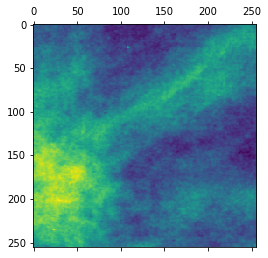

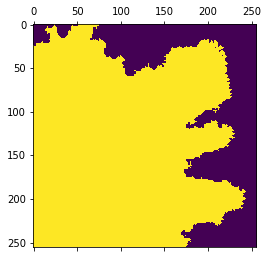

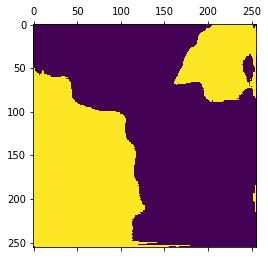

In [16]:
# check
check_model(X_train, Y_train, resunet, 42)

In [17]:
Y_pred = resunet.predict(X_test)
Y_pred_subset = Y_pred[subset]

In [18]:
# pixel-by-pixel accuracy on test set
pixel_acc_m(Y_test, Y_pred)

0.892754768691925

In [19]:
# pixel-by-pixel accuracy on test set samples
pixel_acc_m(Y_test_subset, Y_pred_subset)

0.8982115246000744

In [20]:
# diagnosis accuracy on test set
diagnosis_acc_m(Y_test, Y_pred)

0.7052270779777207

In [21]:
# diagnosis accuracy on test set samples
diagnosis_acc_m(Y_test_subset, Y_pred_subset)

0.6716791979949874

In [22]:
# intersection over union on test set
IoU_m(Y_test, Y_pred)

0.31190696

In [23]:
# intersection over union on test set samples
IoU_m(Y_test_subset, Y_pred_subset)

0.3307232

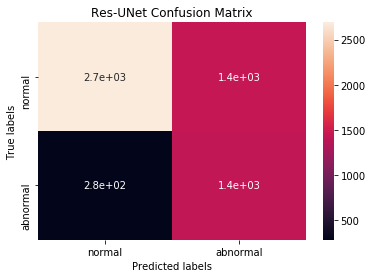

In [24]:
# draw confusion matrix
class_test = map_df_test.iloc[:,2].values

class_test_pred = np.round(Y_pred).reshape((-1, 256*256))
class_test_pred = np.max(class_test_pred, axis=1)

matrix = confusion_matrix(class_test,class_test_pred)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Res-UNet Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);

# Comparing the Networks

The performance of the networks we used are summarized as follows:

| Model                     | diagnosis accuracy | pixel-by-pixel accuracy | IoU   | diagnosis accuracy (sample) | pixel-by-pixel accuracy (sample) | IoU (sample) |
|---------------------------|--------------------|-------------------------|-------|-----------------------------|----------------------------------|--------------|
| baseline 1 (all abnormal) | --                 | --                      | --    | 0.078                       | 0.300                            | 0.078        |
| baseline 2 (all normal)   | --                 | --                      | --    | 0.922                       | 0.700                            | 0.000        |
| ResNet                    | 0.769              | --                      | --    | 0.793                       | 0.881                            | 0.007        |
| UNet                      | 0.708              | 0.906                   | 0.267 | 0.713                       | 0.911                            | 0.269        |
| UNet with ResNet Backbone | 0.705              | 0.893                   | 0.312 | 0.705                       | 0.898                            | 0.330        |

Among all our networks, ResNet has the best diagnosis accuracy. UNet has the highest pixel-by-pixel accuracy and UNet with ResNet Backbone has the highest intersection over union. 

We can see there is a accuracy-interpretability tradeoff in our cancer detection task. ResNet is better at classifying whether an image contains cancerous area, yet it is not easy to understand how it comes to the prediction. UNet explicitly labels the area it find suspicious, yet it has lower diagnosis accuracy. UNet with ResNet backbone has better intersection over union (another interpretability metrics in our project) compared to vanilla UNet, yet it has slightly wrose pixel-by-pixel accuracy, so there is also a tradeoff between different forms of interpretability.

# Reference

Drozdzal, Michal, et al. "The importance of skip connections in biomedical image segmentation." Deep Learning and Data Labeling for Medical Applications. Springer, Cham, 2016. 179-187.